In [1]:
#!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 7.8 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
#from visualkeras import layered_view
prelu=tf.keras.layers.PReLU

In [2]:
def encoder_block(inputs, num_filters,dropout_rate):
    x = tf.keras.layers.Conv2D(num_filters,(3,3), padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = prelu()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    return x

def decoder_block(inputs, skip_features, num_filters,dropout_rate):
    # deconvolution with prelu
    x = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides = 2, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = prelu()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    # forward fine grained features
    skip_features = tf.image.resize(skip_features, size = (x.shape[1], x.shape[2]))
    x = tf.keras.layers.Concatenate()([x, skip_features])
    return x


def tower(inputs, num_filters1, num_filters2, num_filters_target, strides1, strides2, strides3, strides4,dropout_rate):
    c1 = tf.keras.layers.Conv2D(num_filters1,(3,3), padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    tower_1 = tf.keras.layers.MaxPooling2D(pool_size = strides1, strides=strides1, padding='same')(c1)
    c1=tf.keras.layers.BatchNormalization()(c1)
    tower_1 = tf.keras.layers.Dropout(rate=dropout_rate)(tower_1)
    tower_1 = tf.keras.layers.Conv2D(num_filters_target, (3,3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(tower_1)
    tower_1 = tf.keras.layers.MaxPooling2D(pool_size = strides2, strides=strides2, padding='same')(tower_1)
    tower_1=tf.keras.layers.BatchNormalization()(tower_1)
    tower_1 = tf.keras.layers.Dropout(rate=dropout_rate)(tower_1)


    tower_2 = tf.keras.layers.Conv2D(num_filters2,(3,3), padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    tower_2 = prelu()(tower_2)
    tower_2 = tf.keras.layers.MaxPool2D(pool_size = strides3, strides = strides3)(tower_2)
    tower_2=tf.keras.layers.BatchNormalization()(tower_2)
    tower_2 = tf.keras.layers.Dropout(rate=dropout_rate)(tower_2)
    tower_2 = tf.keras.layers.Conv2D(num_filters_target,(3,3), padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.001))(tower_2)
    tower_2 = prelu()(tower_2)
    tower_2 = tf.keras.layers.MaxPool2D(pool_size = strides4, strides = strides4)(tower_2)
    tower_2=tf.keras.layers.BatchNormalization()(tower_2)
    tower_2 = tf.keras.layers.Dropout(rate=dropout_rate)(tower_2)
    merged = tf.keras.layers.concatenate([tower_1, tower_2], axis=1)
    return merged

In [11]:
def unet_model(input_shape = (512, 512, 3), num_filters=512, num_classes = 10, dropout_rate=0.2):
    inputs = tf.keras.layers.Input(input_shape)

    #       BLOCK 1

    #convolution with prelu
    c1 = tf.keras.layers.Conv2D(num_filters/32,(3,3), padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    c1 = prelu()(c1)
    c1 = tf.keras.layers.MaxPool2D(pool_size = 1, strides = 1)(c1)
    c1=tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Dropout(rate=dropout_rate)(c1)

    # Contracting Path
    s1 = encoder_block(c1, num_filters/16,dropout_rate)
    s2 = encoder_block(s1, num_filters/8,dropout_rate)
    s3 = encoder_block(s2, num_filters/4,dropout_rate)


    # Bottleneck
    b1 = tf.keras.layers.Conv2D(num_filters/2, (3,3), padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(s3)
    b1 = prelu()(b1)
    b1 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(b1)
    b1=tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Dropout(rate=dropout_rate)(b1)

    # Expansive Path
    s4 = decoder_block(b1, s3, num_filters/4,dropout_rate)
    s5 = decoder_block(s4, s2, num_filters/8,dropout_rate)
    s6 = decoder_block(s5, s1, num_filters/16,dropout_rate)


    #forward fine grained features with deconvolution
    c2 = tf.keras.layers.Conv2DTranspose(num_filters/32, (2, 2), strides = 2, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(s6)
    c2 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c2)
    c2=tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Dropout(rate=dropout_rate)(c2)

    #       BLOCK 2

    #parallel convolutions
    pc1=tower(c2 , num_filters/4 ,num_filters/8  ,num_filters/4 ,   1,1,1,1,dropout_rate)
    pc2=tower(pc1, num_filters/4 ,num_filters/2 ,num_filters/2 ,   1,1,1,1,dropout_rate)
    pc3=tower(pc2, num_filters/2 ,num_filters/1 ,num_filters*2,   1,4,2,2,dropout_rate)
    pc4=tower(pc3, num_filters*2,num_filters*4,num_filters*4,   1,2,2,1,dropout_rate)
    #flatten
    flattened=tf.keras.layers.Flatten()(pc4)

    #dense layers
    d1=tf.keras.layers.Dense(num_filters*2,kernel_regularizer=tf.keras.regularizers.l2(0.01))(flattened)
    d1=prelu()(d1)
    d1=tf.keras.layers.BatchNormalization()(d1)
    d1=tf.keras.layers.Dropout(rate=dropout_rate)(d1)

    d2=tf.keras.layers.Dense(num_filters,kernel_regularizer=tf.keras.regularizers.l2(0.01))(flattened)
    d2=prelu()(d2)
    d2=tf.keras.layers.BatchNormalization()(d2)
    d2=tf.keras.layers.Dropout(rate=dropout_rate)(d2)


    #       OUTPUT
    outputs = tf.keras.layers.Dense(num_classes, activation = 'softmax',kernel_regularizer=tf.keras.regularizers.l2(0.01))(d2)

    model = tf.keras.models.Model(inputs = inputs, outputs = outputs, name = 'U-Net')
    return model

In [14]:
#create model
model = unet_model(input_shape=(128, 1290, 1),num_filters=256, num_classes=10)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 1290, 1)]       0         []                            
                                                                                                  
 conv2d_126 (Conv2D)         (None, 128, 1290, 8)         80        ['input_7[0][0]']             
                                                                                                  
 p_re_lu_101 (PReLU)         (None, 128, 1290, 8)         1320960   ['conv2d_126[0][0]']          
                                                                                                  
 max_pooling2d_150 (MaxPool  (None, 128, 1290, 8)         0         ['p_re_lu_101[0][0]']         
 ing2D)                                                                                       

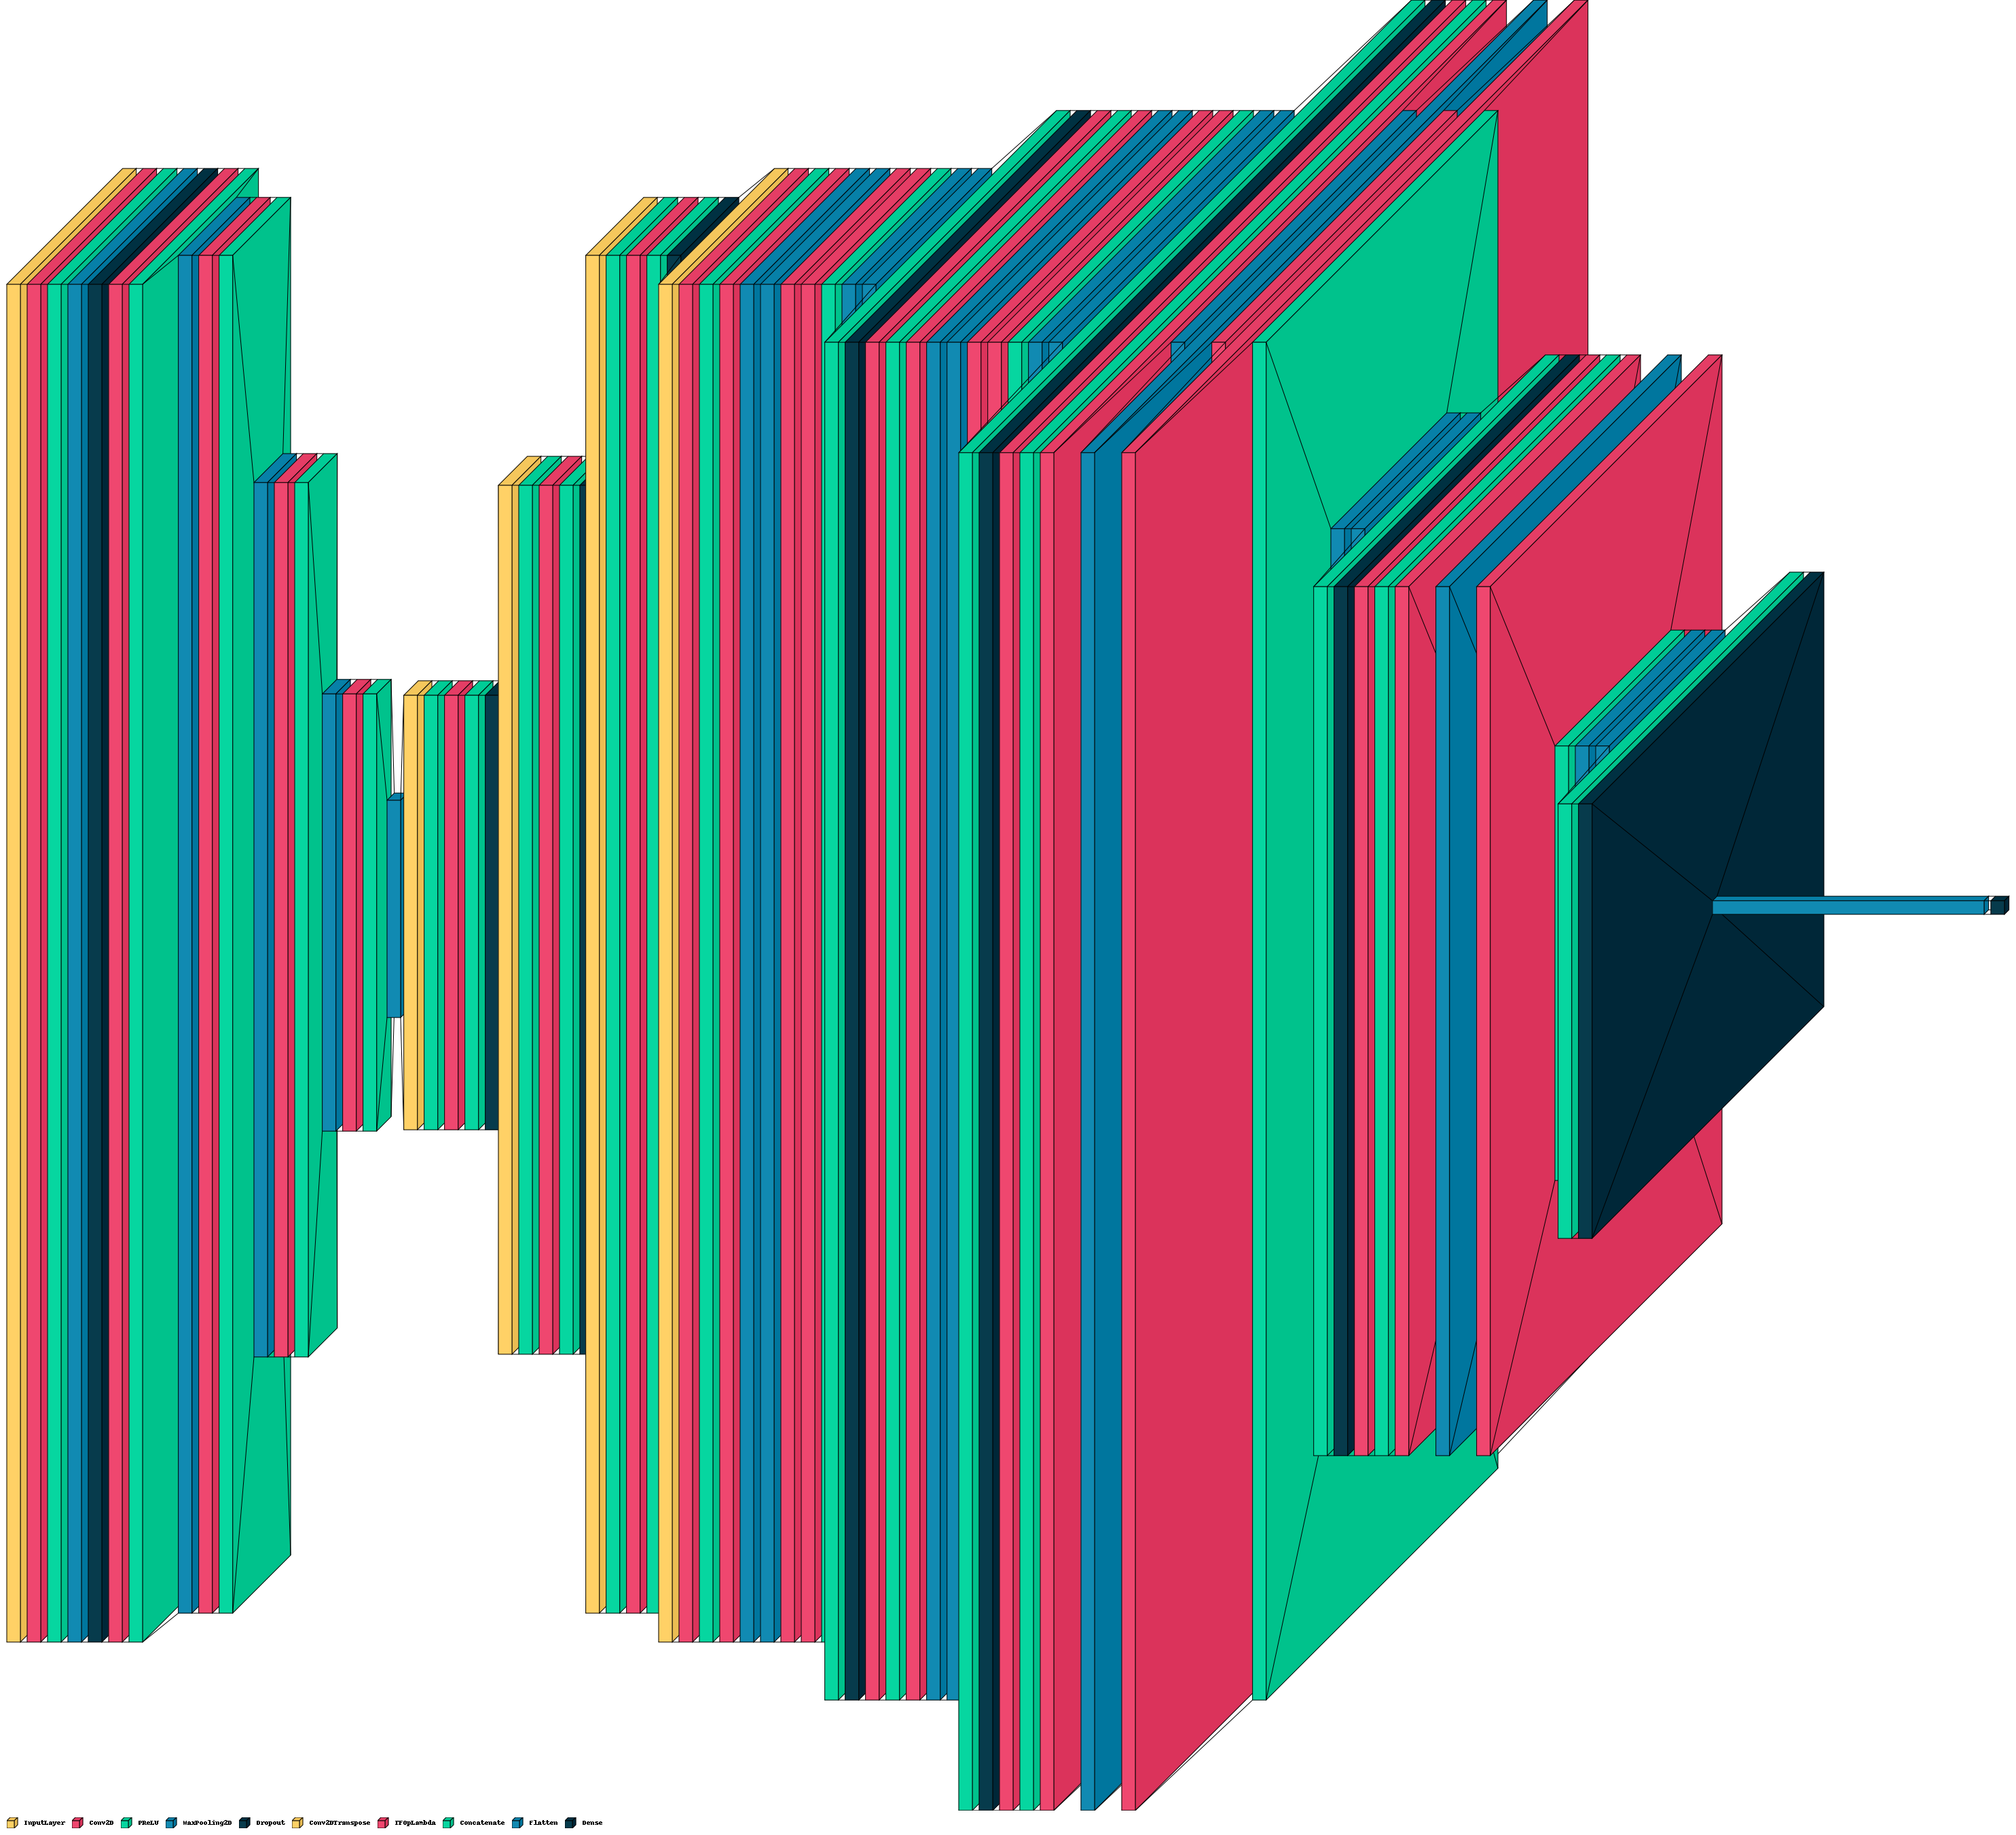

In [6]:
layered_view(model, legend = True)

In [7]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
#get dataset on colab
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [9]:
from zipfile import ZipFile
#extract the dataset
with ZipFile(fname, 'r') as zipObj:
  zipObj.extractall()

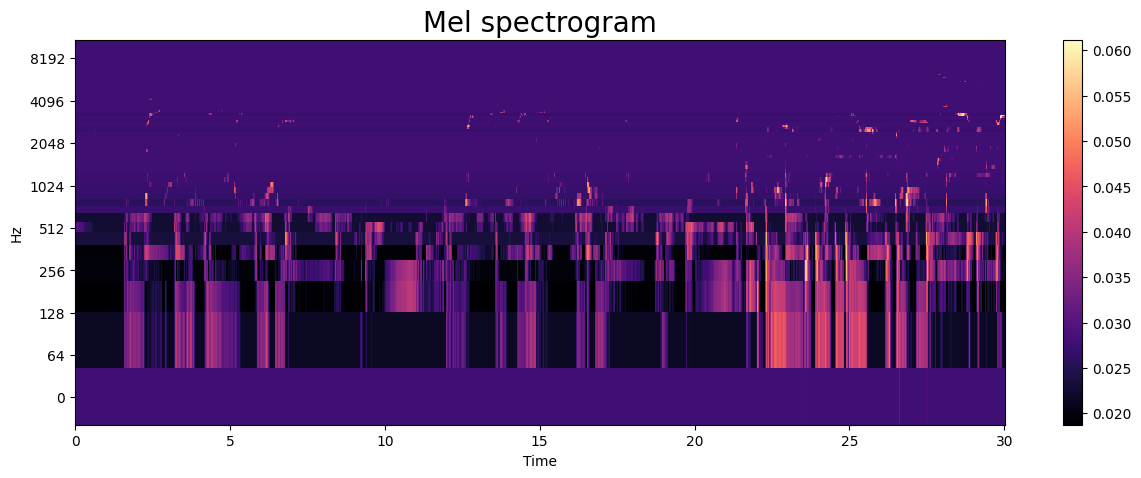

In [50]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
# Convert sound wave to mel spectrogram. trying this on a sample audio
sample_path = '../trash/pop.00006.wav'

y, sr = librosa.load(sample_path)

#        norm_spect = normalize(spect)

S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S**2)
S_DB=normalize(S_DB)
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.show()

In [ ]:
# Data Augmentation

#white noise
def noise_addition(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

#time shift
def time_shift(data, sampling_rate, shift_max):
    shift = np.random.randint(sampling_rate * shift_max)
    augmented_data = np.roll(data, shift)
    return augmented_data

#stretch, only works with speed_factor=2 (need to change the split to preserve
#the spectrogram size otherwise)
def time_stretch(data, speed_factor=2):
    samples = np.array_split(data, 3)
    data1=librosa.effects.time_stretch(samples[0], rate=1/speed_factor)
    data2=librosa.effects.time_stretch(samples[1], rate=speed_factor)
    data3=librosa.effects.time_stretch(samples[2], rate=speed_factor)
    return np.concatenate([data1,data2,data3])

#pitch shift
def pitch_shift(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

#all techniques together
def augment_data(data, sampling_rate, noise_factor, shift_max, pitch_factor):
    augmented_data = noise_addition(data, noise_factor)
    augmented_data = time_shift(augmented_data, sampling_rate, shift_max)
    augmented_data = pitch_shift(augmented_data, sampling_rate, pitch_factor)
    augmented_data=time_stretch(augmented_data)
    return augmented_data

In [ ]:
fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()

#original
spec = librosa.feature.melspectrogram(y=y, sr=sr)
spec = librosa.amplitude_to_db(spec**2)
axs[0].set_title("Mel spectrogram", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[0])

#all augmentations
yhat=augment_data(y,sr*2,0.15,4,4)
spec = librosa.feature.melspectrogram(y=yhat, sr=sr)
spec = librosa.amplitude_to_db(spec**2)
axs[1].set_title("All augmentation techniques", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[1])

#wn
yhat=noise_addition(y,0.15)
spec = librosa.feature.melspectrogram(y=yhat, sr=sr)
spec = librosa.amplitude_to_db(spec**2)
axs[2].set_title("White noise", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[2])

#time shift
yhat=time_shift(y,sr*2,8)
spec = librosa.feature.melspectrogram(y=yhat, sr=sr)
spec = librosa.amplitude_to_db(spec**2)
axs[3].set_title("Time shift", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[3])

#pitch shift
yhat=pitch_shift(y,sr*2,4)
spec = librosa.feature.melspectrogram(y=yhat, sr=sr)
spec = librosa.amplitude_to_db(spec**2)
axs[4].set_title("Pitch shift", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[4])

#pitch shift
yhat=time_stretch(y)
spec = librosa.feature.melspectrogram(y=yhat, sr=sr)
spec = librosa.amplitude_to_db(spec**2)
axs[5].set_title("Time stretch", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[5])

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)

In [11]:
#testing with different audio samples,it is possible to see that the resulting
#spectrogram is not always the same size (the audios differ for some milliseconds)
#so, it is necessary to only consider the size 128x1290 (minimum size that all
#spectrograms have) and disregard other values to keep it consistent
print(S_DB.shape)
S_DB=S_DB[None,:128,:1290,None]
S_DB.shape

(128, 1292)


(1, 128, 1290, 1)

In [12]:
#all genres within the dataset
data_path = 'Data/genres_original/'
genres = [folder for folder in os.listdir(data_path)]
genres

['jazz',
 'metal',
 'classical',
 'reggae',
 'blues',
 'country',
 'pop',
 'rock',
 'hiphop',
 'disco']

In [13]:
#corrupted audio
os.remove('Data/genres_original/jazz/jazz.00054.wav')

In [24]:
from sklearn.model_selection import train_test_split

#preprocessing function to get the spectrogram from the audio
def load_audio(file_path, target_shape):
    audio, sr = librosa.load(file_path, sr=22050)
    #spectrogram = librosa.feature.mfcc(y=audio, sr=22050)
    #return spectrogram

    #or, melspectrogram:
    spectrogram=librosa.feature.melspectrogram(y=audio,sr=sr)
    specdb = librosa.amplitude_to_db(spectrogram**2)
    #check to see if some audios have smaller size
    if specdb.shape[0]<128 or specdb.shape[1]<1290:
      print(file_path)
    specdb=specdb[:128,:1290,None]
    return specdb


# data preparation
Xpy = []
y = []
data_path = 'Data/genres_original/'
genres = [folder for folder in os.listdir(data_path)]
for i, genre in enumerate(genres):
    genre_dir = os.path.join(data_path, genre)
    for filename in os.listdir(genre_dir):
        file_path = os.path.join(genre_dir, filename)
        audio = load_audio(file_path, target_shape=(512, 512))
        Xpy.append(audio)
        y.append(i)

X = np.array(Xpy)
#normalization
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
y = np.array(y)

# Split dataset into train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#check to see if training set is balanced
print([y_train[y_train==i].shape[0] for i in range(10)])

In [15]:
#training with whole dataset causes colab to crash because of ram
#so we need to use a generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.x_data))

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x = self.x_data[batch_indexes]
        batch_y = self.y_data[batch_indexes]
        return batch_x, batch_y

trainset = DataGenerator(X_train, y_train, batch_size=4)
validset = DataGenerator(X_valid, y_valid, batch_size=4)

In [44]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [45]:
#batch size of 32 crashes colab :D
history = model.fit(trainset, epochs=5, validation_data=validset)

Epoch 1/5
200/200 [==============================] - 28s 47ms/step - loss: 3.9302 - accuracy: 0.1615 - val_loss: 11.7058 - val_accuracy: 0.1200
Epoch 2/5
200/200 [==============================] - 8s 38ms/step - loss: 3.2942 - accuracy: 0.2203 - val_loss: 10.8792 - val_accuracy: 0.0550
Epoch 3/5
200/200 [==============================] - 8s 41ms/step - loss: 3.1072 - accuracy: 0.2741 - val_loss: 30.0114 - val_accuracy: 0.0550
Epoch 4/5
200/200 [==============================] - 8s 40ms/step - loss: 2.6656 - accuracy: 0.3004 - val_loss: 6.7941 - val_accuracy: 0.1650
Epoch 5/5
200/200 [==============================] - 7s 37ms/step - loss: 2.4938 - accuracy: 0.3179 - val_loss: 5.0561 - val_accuracy: 0.1000


In [23]:
import json
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
#compute mean spectrograms for each genre
mean_spectrograms=[]
for i, genre in enumerate(genres):
    genre_dir = os.path.join(data_path, genre)
    genre_spectrograms=[]
    for filename in os.listdir(genre_dir):
        file_path = os.path.join(genre_dir, filename)
        audio = load_audio(file_path, target_shape=(512, 512))
        genre_spectrograms.append(audio)
    genre_spectrograms=np.array(genre_spectrograms)
    mean_spectrograms.append(np.mean(genre_spectrograms,axis=0))

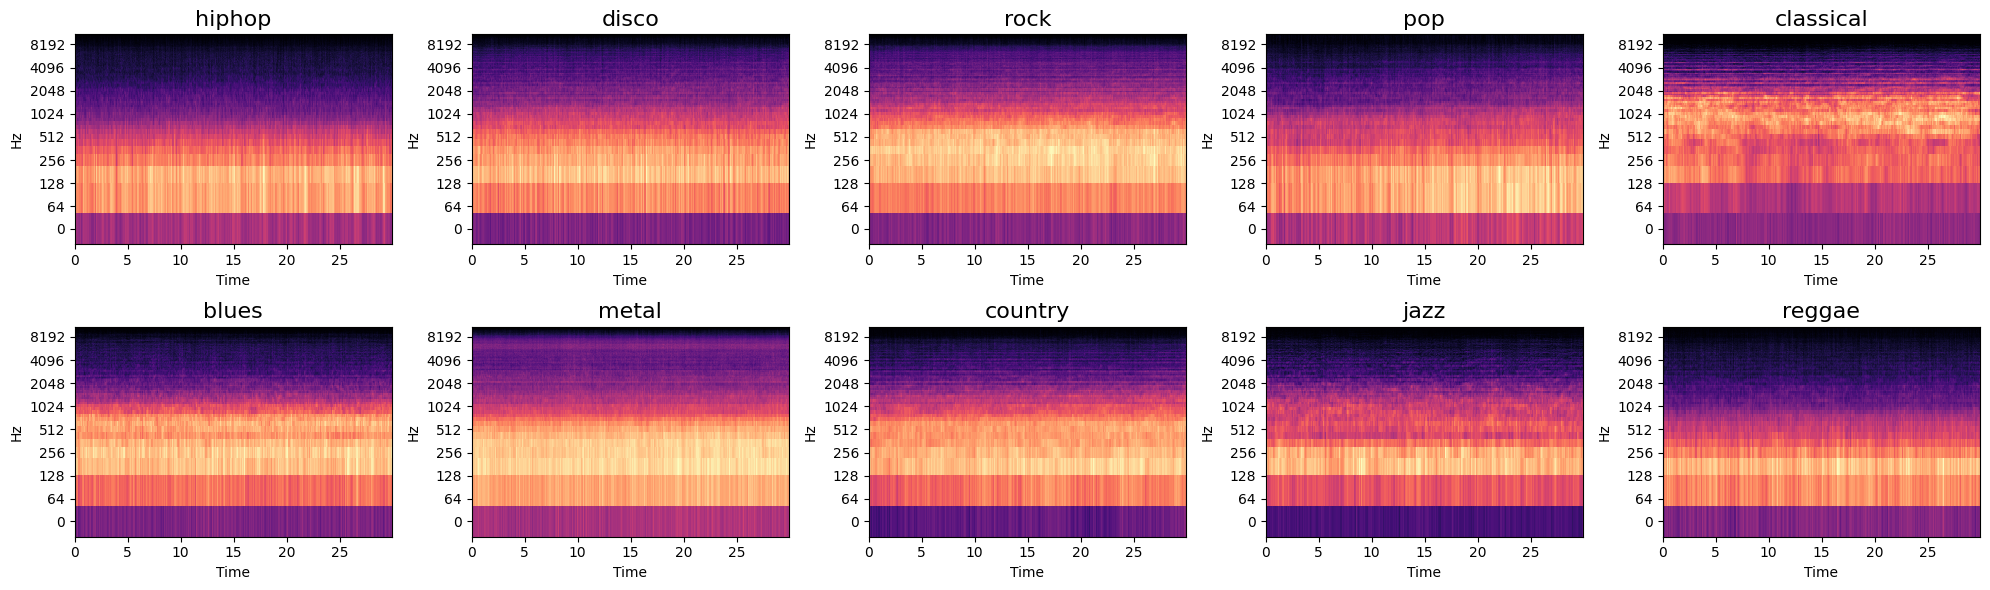

In [ ]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (20,6))
axs = axs.reshape((-1,))

for i,genre in enumerate(genres):
  spec=np.reshape(mean_spectrograms[i],(128,1290))
  librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log', ax=axs[i])
  axs[i].set_title(genre, fontsize=16)
  #plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [33]:
#get prediction for all dataset
yhat=[]
truey=[]
for i,song in enumerate(Xpy):
  song = np.expand_dims(song, axis=0)
  prova = np.expand_dims(song, axis=-1)
  res=np.argmax(model.predict(song))
  yhat.append(res)
  truey.append(y[i])


1/1 [==============================] - 0s 21ms/step


In [34]:
#save results to file
truey=[int(x) for x in truey]
yhat=[int(x) for x in yhat]
with open('true.json','w') as f:
  json.dump(truey,f)
with open('predicted.json','w') as f:
  json.dump(yhat,f)

In [21]:
yhat

[]

In [19]:
prova = np.expand_dims(Xpy[0], axis=0)
prova = np.expand_dims(prova, axis=-1)
model.predict(prova)

1/1 [==============================] - 4s 4s/step


array([[0.02754759, 0.3316697 , 0.07958022, 0.1597121 , 0.0263876 ,
        0.07557681, 0.01357035, 0.00244158, 0.2795267 , 0.00398737]],
      dtype=float32)